In [2]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
from sklearn.utils import shuffle

print('All modules imported.')

d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\self learning\anaconda3\envs\tf1.4.0\lib\site-packages\ten

All modules imported.


# 1. Reload the preprocessed data

In [3]:
# 1 Reload the preprocessed data

pickle_file = './pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2. Model Architecture
## 2.1 Inception model and GoogLeNet


In [4]:
def Inception(inputs, conv11_size, conv33_11_size, conv33_size, conv55_11_size, conv55_size,pool11_size):
        conv11 = layers.conv2d(inputs,conv11_size,[1,1])
        conv33_reduce = layers.conv2d(inputs,conv33_11_size,[1,1])
        conv33 = layers.conv2d(conv33_reduce, conv33_size,[3,3])
        conv55_reduce = layers.conv2d(inputs,conv55_11_size,[1,1])
        conv55 = layers.conv2d(conv55_reduce,conv55_size,[5,5])
        pool_proj = layers.max_pool2d(inputs,[3,3],stride = 1, padding = 'SAME')
        pool11 = layers.conv2d(pool_proj,pool11_size,[1,1])
        return tf.concat([conv11,conv33,conv55,pool11],3)
def GoogLeNet(inputs, dropout_keep_prob):
    # inputs size: 32x32x3
    conv1 = layers.conv2d(inputs,64,[3,3],stride = 2)  # 16x16x64
    inception_2a = Inception(conv1,64,96,128,16,32,32) # 16x16x480
    inception_2b = Inception(inception_2a,128,128,192,32,96,64) # 16x16x480
    pool2 = layers.max_pool2d(inception_2b,[3,3]) # 7x7x480
    inception_3a = Inception(pool2, 192,96,208,16,48,64)  # 7x7x512
    inception_3b = Inception(inception_3a,160,112,224,24,64,64) # 7x7x512
    pool3 = layers.max_pool2d(inception_3b,[3,3]) # 3x3x512
    inception_4a = Inception(pool3,256,160,320,32,128,128)  # 3x3x832
    inception_4b = Inception(inception_4a,384,192,384,48,128,128) # 3x3x1024
    pool4 = layers.avg_pool2d(inception_4b,[3,3],stride = 1)
    
    reshape = tf.reshape(pool4,[-1,1024])
    dropout = layers.dropout(reshape,dropout_keep_prob)
    logits = layers.fully_connected(dropout,43,activation_fn=None)
    return logits
    
    
    

# 3. Training
## 3.1 Strategy 


In [5]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 4e-4
EPOCHS = 35
BATCH_SIZE = 128

# Train method
logits = GoogLeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_op = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
train_op = optimizer.minimize(loss_op)

## 3.2 Evaluation


In [6]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_op, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## 3.3 Train the Model


In [8]:
%%time
saver = tf.train.Saver()
train_accuracy = []
valid_accuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        total_train_acc = 0
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_acc = sess.run([train_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            total_train_acc += (train_acc * len(batch_x))
        train_accuracy.append(total_train_acc / num_examples)
        valid_acc = evaluate(X_valid, y_valid)
        valid_accuracy.append(valid_acc)
        print("Validation Accuracy = {:.3f}".format(valid_acc))
        
    saver.save(sess, './model/googlenet.ckpt')
    print("Model saved")

Training...
EPOCH 1 : Validation Accuracy = 0.421
EPOCH 2 : Validation Accuracy = 0.849
EPOCH 3 : Validation Accuracy = 0.898
EPOCH 4 : Validation Accuracy = 0.945
EPOCH 5 : Validation Accuracy = 0.955
EPOCH 6 : Validation Accuracy = 0.962
EPOCH 7 : Validation Accuracy = 0.933
EPOCH 8 : Validation Accuracy = 0.948
EPOCH 9 : Validation Accuracy = 0.971
EPOCH 10 : Validation Accuracy = 0.958
EPOCH 11 : Validation Accuracy = 0.975
EPOCH 12 : Validation Accuracy = 0.978
EPOCH 13 : Validation Accuracy = 0.976
EPOCH 14 : Validation Accuracy = 0.977
EPOCH 15 : Validation Accuracy = 0.967
EPOCH 16 : Validation Accuracy = 0.961
EPOCH 17 : Validation Accuracy = 0.979
EPOCH 18 : Validation Accuracy = 0.973
EPOCH 19 : Validation Accuracy = 0.977
EPOCH 20 : Validation Accuracy = 0.978
EPOCH 21 : Validation Accuracy = 0.981
EPOCH 22 : Validation Accuracy = 0.975
EPOCH 23 : Validation Accuracy = 0.961
EPOCH 24 : Validation Accuracy = 0.977
EPOCH 25 : Validation Accuracy = 0.982
EPOCH 26 : Validation 

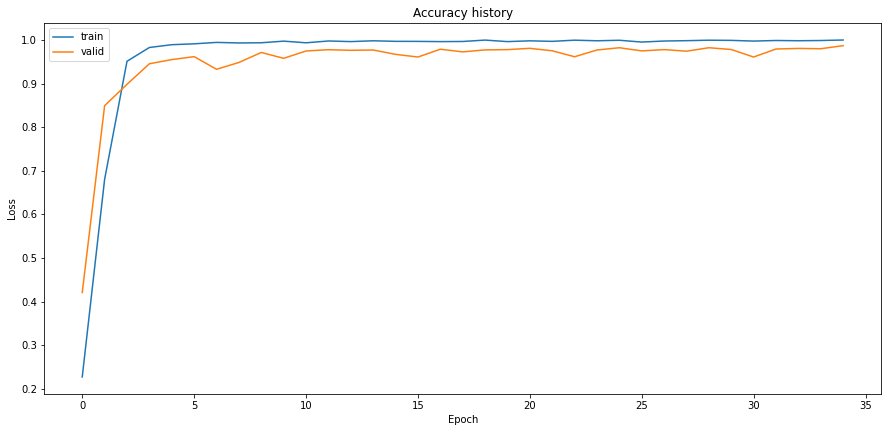

In [9]:
plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 15)
plt.legend()
plt.show()

# 4. Testing
## 4.1 Test the model on testing dataset


In [10]:

saver = tf.train.import_meta_graph('./model/googlenet.ckpt.meta')
with tf.Session() as sess:
    saver.restore(sess, './model/googlenet.ckpt')

INFO:tensorflow:Restoring parameters from ./model/googlenet.ckpt


INFO:tensorflow:Restoring parameters from ./model/googlenet.ckpt


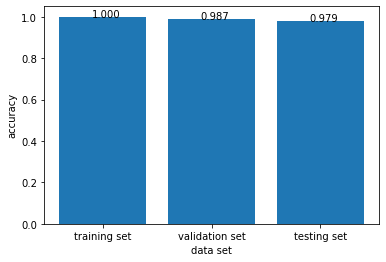

In [11]:
with tf.Session() as sess:
    saver.restore(sess, './model/googlenet.ckpt')
#     sess.run(tf.global_variables_initializer())
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()